In [257]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as smi
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN,GRU,Dropout
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import Adam
import warnings
warnings.simplefilter('ignore')

In [258]:
# Print many statements at same time using the below command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

In [259]:
# Read Source file
file_path = "PepperData2019-24-latest-Till-Feb2025.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")
df["Date"] = pd.to_datetime(df["Date"]).dt.strftime("%m-%d-%y")
print(df.head())


        Market      Date  Arrivals    Min    Max  Modal          District
0  BELTHANGADI  01-01-19        28  32000  32000  32000  Dakshina Kannada
1  BELTHANGADI  01-02-19        15  26000  26000  26000  Dakshina Kannada
2  BELTHANGADI  01-07-19         2  33840  33840  33840  Dakshina Kannada
3  BELTHANGADI  01-19-19        43  32000  33000  32010  Dakshina Kannada
4  BELTHANGADI  01-29-19        20  32500  34000  33000  Dakshina Kannada


In [260]:
# check Districts which has lot of datapoints for model 
dist_counts = df.groupby('District').size().reset_index(name='Row Count')
dist_counts = dist_counts.sort_values(by='Row Count', ascending=False)
print(dist_counts)

            District  Row Count
13    Uttara Kannada       4103
6   Dakshina Kannada       2213
4     Chikkamagaluru       1340
9             Kodagu        862
11        Shivamogga        641
12             Udupi        626
8             Hassan        397
7         Davanagere        182
3   Bengaluru Urban•        139
1    Bengaluru Rural         23
0           Belagavi          1
2    Bengaluru Urban          1
5        Chitradurga          1
10            Koppal          1


### Check for outlier

<Axes: ylabel='Max'>

Text(0.5, 1.0, 'Box Plot of Max Price')

<Axes: ylabel='Min'>

Text(0.5, 1.0, 'Box Plot of Min Price')

<Axes: ylabel='Modal'>

Text(0.5, 1.0, 'Box Plot of Modal Price')

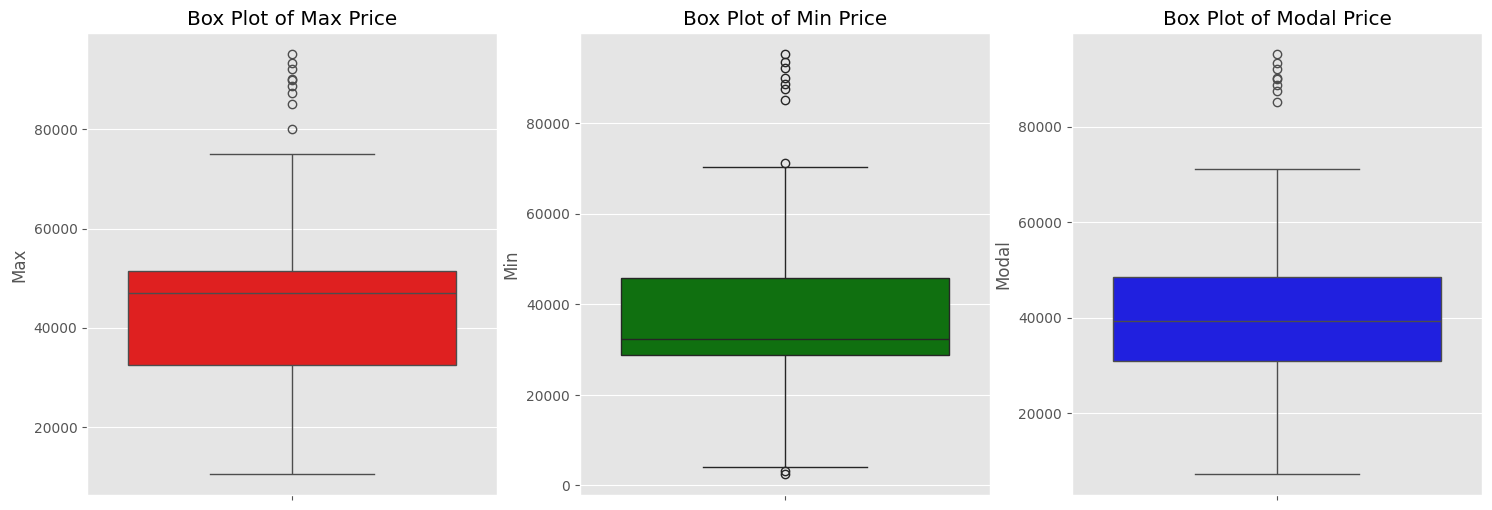

In [262]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")  
df_copy = df[df['District'].isin(['Uttara Kannada', 'Dakshina Kannada', 'Udupi'])]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(y=df_copy['Max'], ax=axes[0], color='red')
axes[0].set_title("Box Plot of Max Price")

sns.boxplot(y=df_copy['Min'], ax=axes[1], color='green')
axes[1].set_title("Box Plot of Min Price")

sns.boxplot(y=df_copy['Modal'], ax=axes[2], color='blue')
axes[2].set_title("Box Plot of Modal Price")

plt.show()

### Remove Outliers for model

In [264]:
import pandas as pd
import numpy as np

# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for all three price columns
filtered_df = remove_outliers(df_copy, 'Max')
filtered_df = remove_outliers(filtered_df, 'Min')
filtered_df = remove_outliers(filtered_df, 'Modal')

# Reset index
filtered_df.reset_index(drop=True, inplace=True)

print("Outliers removed. Dataset ready for modeling!")
print(filtered_df.head())  # Check the cleaned dataset


Outliers removed. Dataset ready for modeling!
        Market      Date  Arrivals    Min    Max  Modal          District
0  BELTHANGADI  01-01-19        28  32000  32000  32000  Dakshina Kannada
1  BELTHANGADI  01-02-19        15  26000  26000  26000  Dakshina Kannada
2  BELTHANGADI  01-07-19         2  33840  33840  33840  Dakshina Kannada
3  BELTHANGADI  01-19-19        43  32000  33000  32010  Dakshina Kannada
4  BELTHANGADI  01-29-19        20  32500  34000  33000  Dakshina Kannada


In [265]:
print(filtered_df)
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])
grouped_df = filtered_df.groupby('Date').agg(
    Max=('Max', 'mean'),
    Min=('Min', 'mean'),
    Modal=('Modal', 'mean'),
    Sum_Arrival=('Arrivals', 'mean')  
).reset_index()

grouped_df.set_index('Date', inplace=True)

date_range = pd.date_range(start=grouped_df.index.min(), end=grouped_df.index.max())

grouped_df = grouped_df.reindex(date_range, fill_value=np.nan)

grouped_df['Max'].fillna(method='ffill', inplace=True)
grouped_df['Min'].fillna(method='ffill', inplace=True)
grouped_df['Modal'].fillna(method='ffill', inplace=True)
grouped_df['Sum_Arrival'].fillna(method='ffill', inplace=True)  

grouped_df.reset_index(inplace=True)
grouped_df.rename(columns={'index': 'Date'}, inplace=True)

print(grouped_df)


           Market      Date  Arrivals    Min    Max  Modal          District
0     BELTHANGADI  01-01-19        28  32000  32000  32000  Dakshina Kannada
1     BELTHANGADI  01-02-19        15  26000  26000  26000  Dakshina Kannada
2     BELTHANGADI  01-07-19         2  33840  33840  33840  Dakshina Kannada
3     BELTHANGADI  01-19-19        43  32000  33000  32010  Dakshina Kannada
4     BELTHANGADI  01-29-19        20  32500  34000  33000  Dakshina Kannada
...           ...       ...       ...    ...    ...    ...               ...
6925    YELLAPURA  02-21-25         5  47179  62809  61301    Uttara Kannada
6926    YELLAPURA  02-24-25         4  52599  62839  61111    Uttara Kannada
6927    YELLAPURA  02-25-25        20  53415  63509  62399    Uttara Kannada
6928    YELLAPURA  02-27-25         1  55009  63501  62009    Uttara Kannada
6929    YELLAPURA  02-28-25         8  45709  63900  61900    Uttara Kannada

[6930 rows x 7 columns]
           Date           Max           Min        

Text(0.5, 1.0, 'Weekly Max, Min, and Modal Prices Rollup for 24 Weeks')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

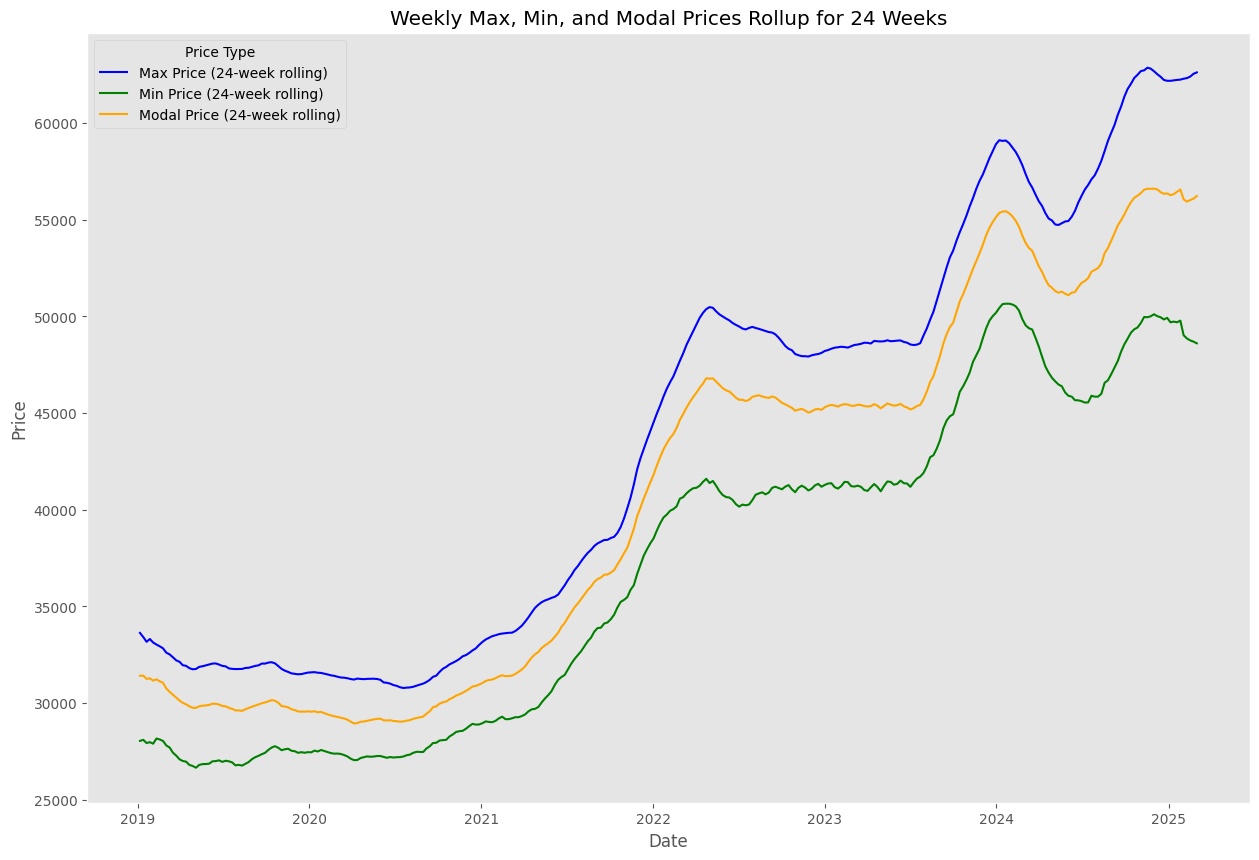

In [266]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Date' column to datetime if not already done
grouped_df['Date'] = pd.to_datetime(grouped_df['Date'])

# Resample the data to get weekly averages (without any district filtering)
df_weekly = grouped_df.resample('W', on='Date').agg({
    'Max': 'mean',
    'Min': 'mean',
    'Modal': 'mean'
}).reset_index()

# Apply rolling mean over a window of 24 weeks for each price
df_weekly['Max_Rolling'] = df_weekly['Max'].rolling(window=24, min_periods=1).mean()
df_weekly['Min_Rolling'] = df_weekly['Min'].rolling(window=24, min_periods=1).mean()
df_weekly['Modal_Rolling'] = df_weekly['Modal'].rolling(window=24, min_periods=1).mean()

# Create a new figure with appropriate size
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the rolling averages for each price type
ax.plot(df_weekly['Date'], df_weekly['Max_Rolling'], label='Max Price (24-week rolling)', color='blue')
ax.plot(df_weekly['Date'], df_weekly['Min_Rolling'], label='Min Price (24-week rolling)', color='green')
ax.plot(df_weekly['Date'], df_weekly['Modal_Rolling'], label='Modal Price (24-week rolling)', color='orange')

# Set plot title and labels
ax.set_title('Weekly Max, Min, and Modal Prices Rollup for 24 Weeks')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.grid()

# Add a legend
ax.legend(title='Price Type')

# Show the plot
plt.show()


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap')

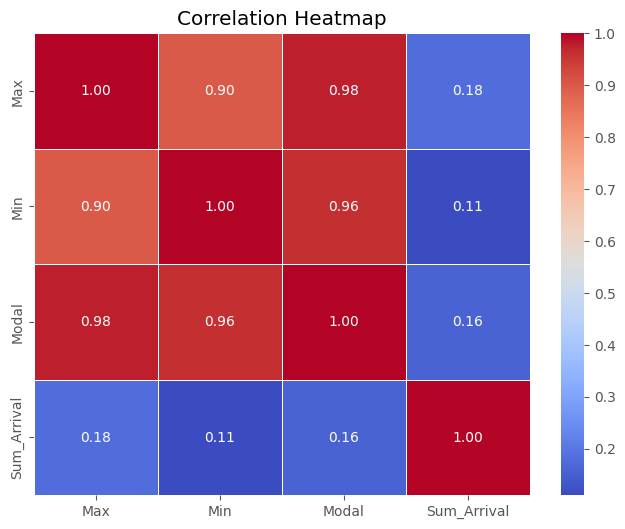

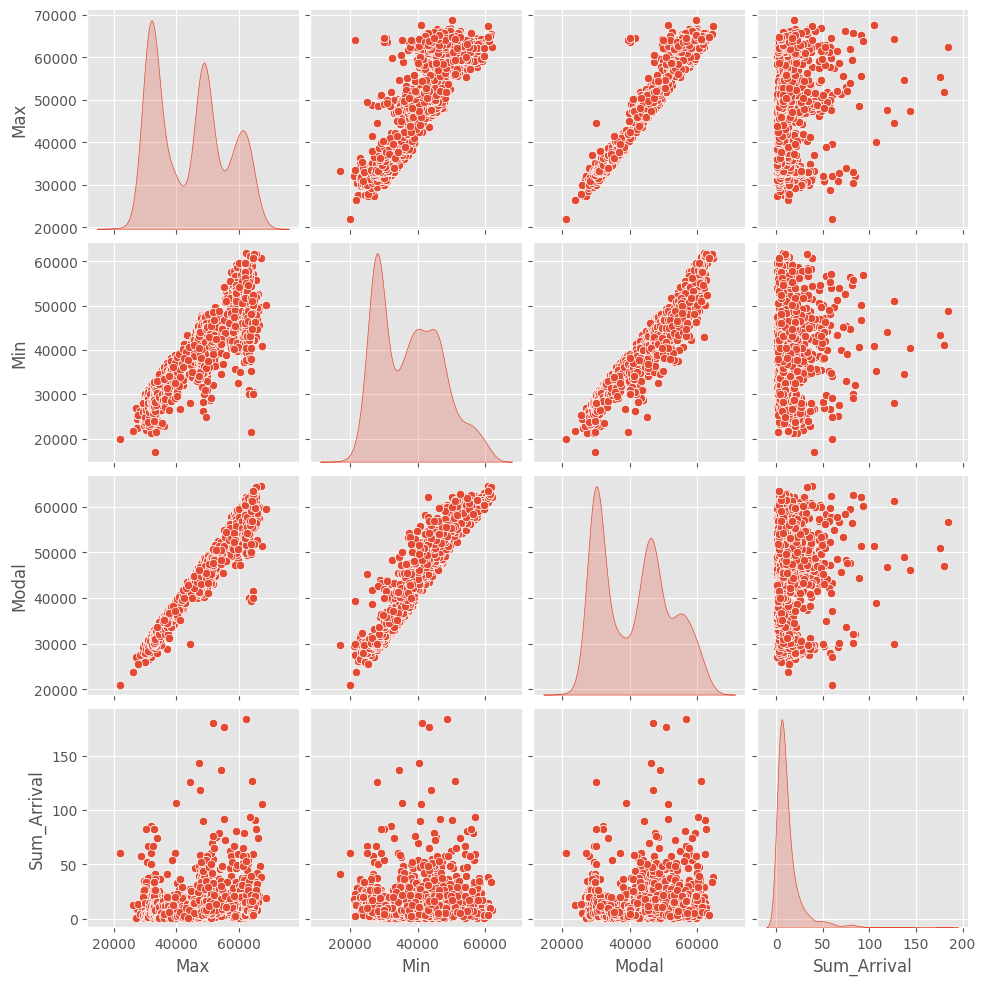

In [267]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = grouped_df.drop(columns=["Date"]).corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Scatterplot Matrix
sns.pairplot(grouped_df.drop(columns=["Date"]), diag_kind="kde")
plt.show()


### compute Autocorrelation Function (ACF) and Partial Cross-correlation Function (PCF/PSCF) for each of your price columns (Max, Min, Modal) and Sum_Arrival.

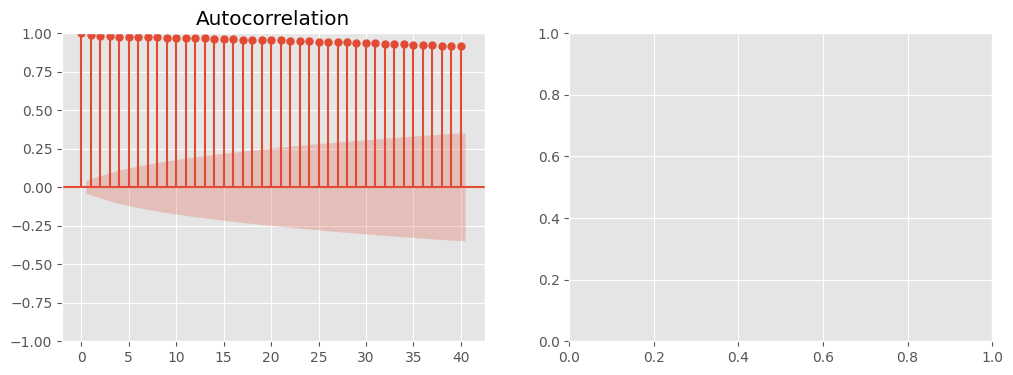

Text(0.5, 1.0, 'Autocorrelation Function (ACF) - Max')

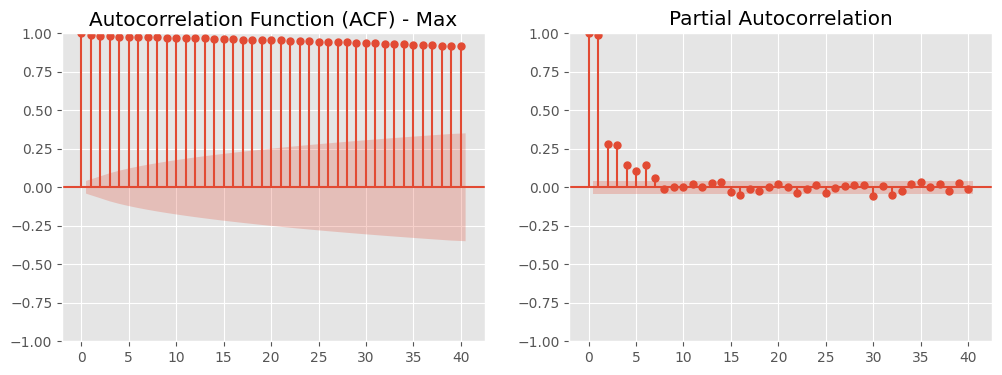

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF) - Max')

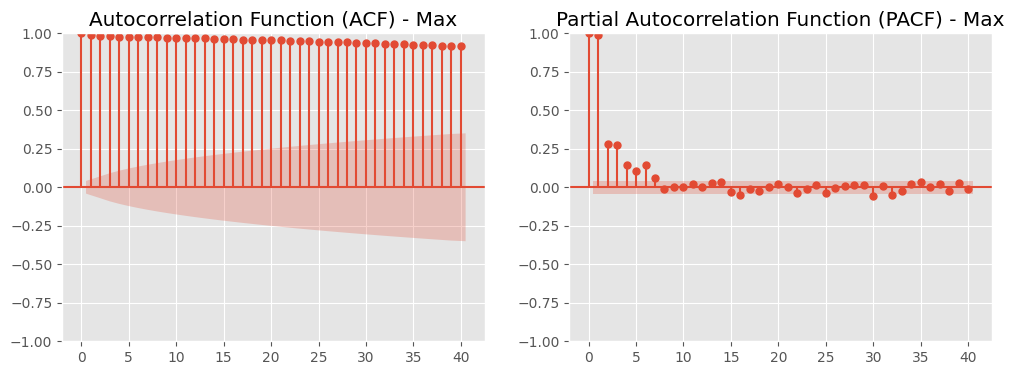

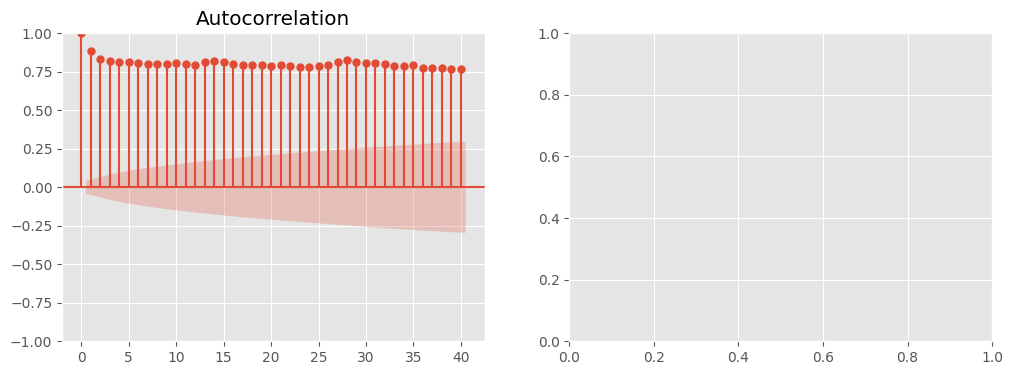

Text(0.5, 1.0, 'Autocorrelation Function (ACF) - Min')

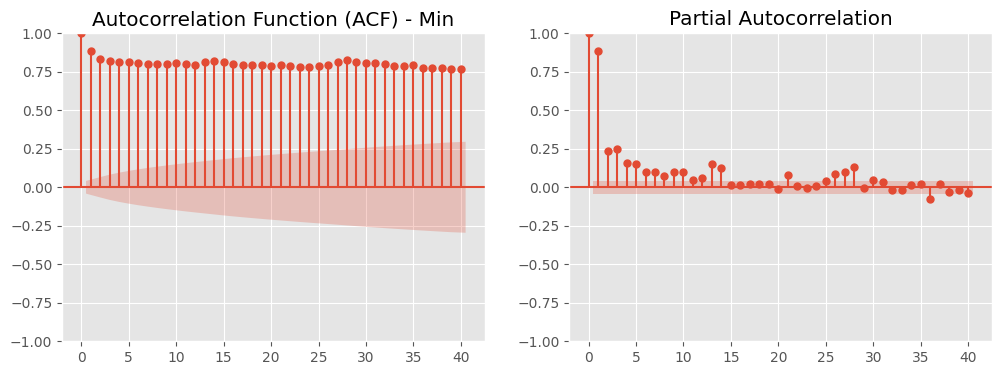

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF) - Min')

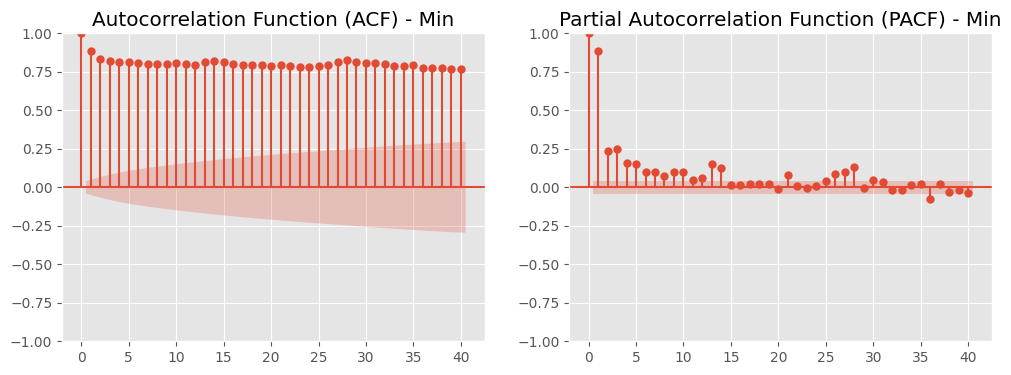

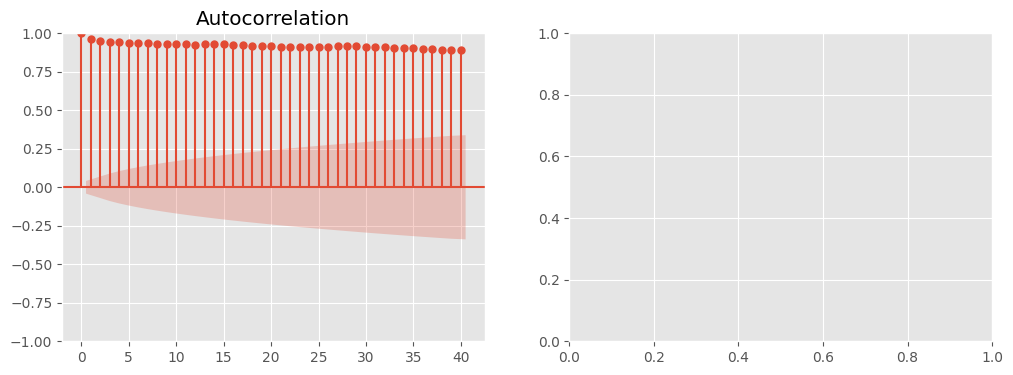

Text(0.5, 1.0, 'Autocorrelation Function (ACF) - Modal')

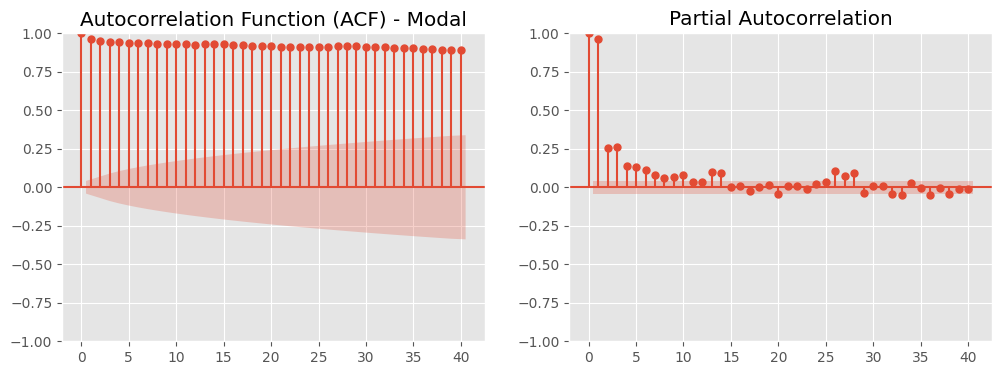

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF) - Modal')

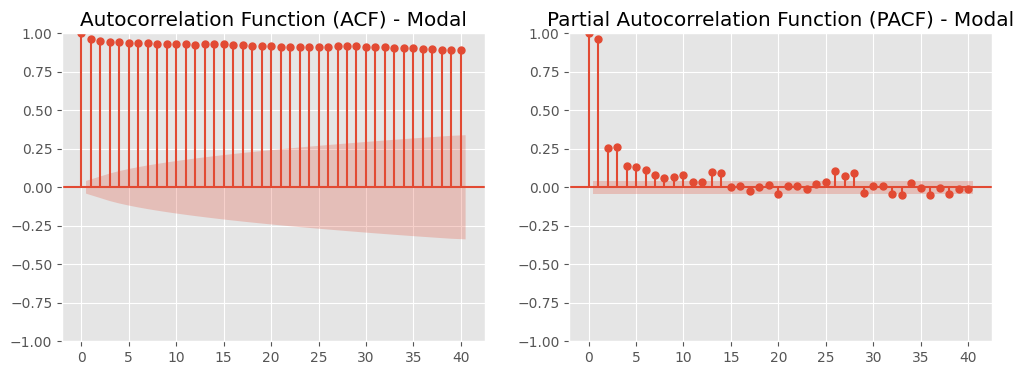

In [269]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Create a copy of grouped_df
df_copy = grouped_df.copy()

# Ensure Date column is in datetime format
df_copy['Date'] = pd.to_datetime(df_copy['Date'])
df_copy.set_index('Date', inplace=True)

# List of price columns
price_columns = ['Max', 'Min', 'Modal']

# Plot ACF and PACF for each price column
for col in price_columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # ACF
    sm.graphics.tsa.plot_acf(df_copy[col].dropna(), lags=40, ax=axes[0])
    axes[0].set_title(f'Autocorrelation Function (ACF) - {col}')
    
    # PACF
    sm.graphics.tsa.plot_pacf(df_copy[col].dropna(), lags=40, ax=axes[1])
    axes[1].set_title(f'Partial Autocorrelation Function (PACF) - {col}')
    
    plt.show()


### Checks stationarity using ADF test for Max, Min, and Modal.If non-stationary, applies first-order differencing (df_copy[col].diff()).Re-runs ADF test on the differenced data to confirm stationarity.Plots ACF & PACF after differencing for each column.



ADF Test for Max:
ADF Statistic: -0.41725033027433917
p-value: 0.9071785041149283
Critical Values:
   1%: -3.4332818554284206
   5%: -2.8628352100913195
   10%: -2.5674595019923636
❌ Max is NOT stationary (Fail to reject H0), applying differencing

ADF Test for Max (Differenced):
ADF Statistic: -12.901330832078145
p-value: 4.2419789673655214e-24
Critical Values:
   1%: -3.4332818554284206
   5%: -2.8628352100913195
   10%: -2.5674595019923636
✅ Max (Differenced) is stationary (Reject H0)


True

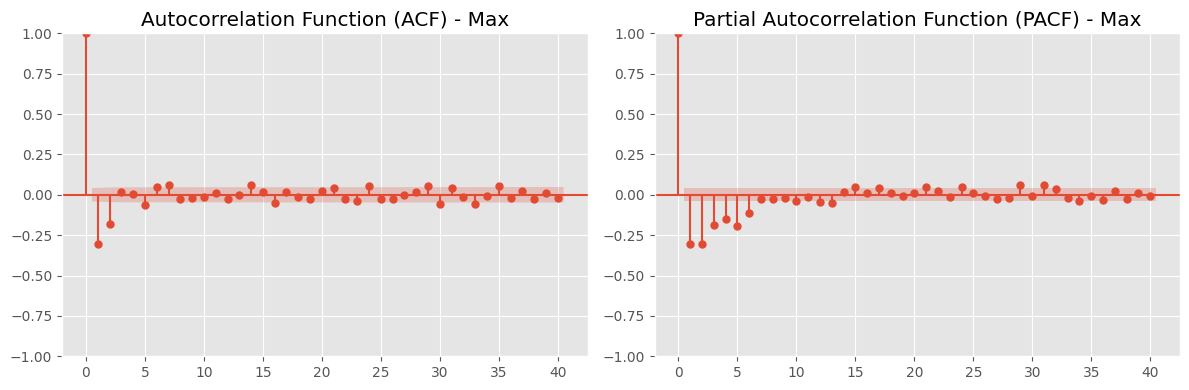


ADF Test for Min:
ADF Statistic: -1.025642019204019
p-value: 0.7437974673497497
Critical Values:
   1%: -3.433295059438173
   5%: -2.8628410403669844
   10%: -2.5674626062113077
❌ Min is NOT stationary (Fail to reject H0), applying differencing

ADF Test for Min (Differenced):
ADF Statistic: -17.77550693719182
p-value: 3.2937650662373655e-30
Critical Values:
   1%: -3.433295059438173
   5%: -2.8628410403669844
   10%: -2.5674626062113077
✅ Min (Differenced) is stationary (Reject H0)


True

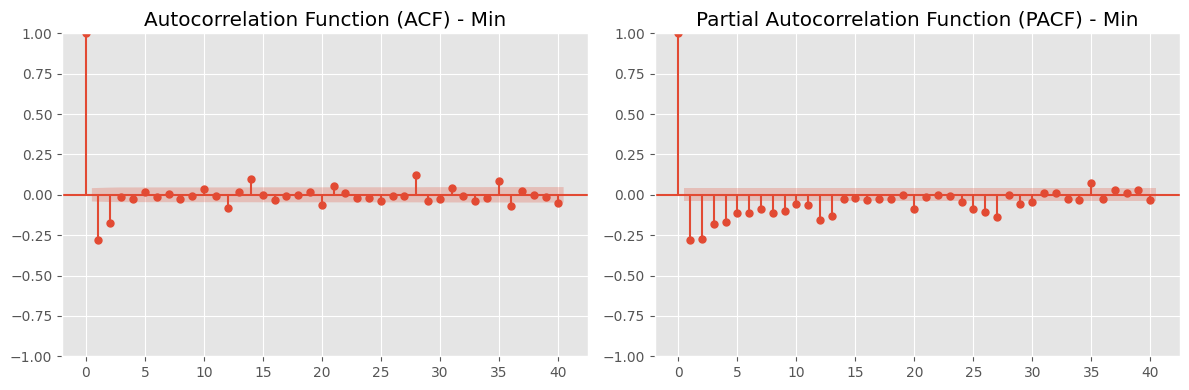


ADF Test for Modal:
ADF Statistic: -0.4024245295742791
p-value: 0.9096931800168357
Critical Values:
   1%: -3.433295059438173
   5%: -2.8628410403669844
   10%: -2.5674626062113077
❌ Modal is NOT stationary (Fail to reject H0), applying differencing

ADF Test for Modal (Differenced):
ADF Statistic: -13.054095436186888
p-value: 2.1124057529689165e-24
Critical Values:
   1%: -3.4332963863833688
   5%: -2.8628416262827505
   10%: -2.567462918171205
✅ Modal (Differenced) is stationary (Reject H0)


True

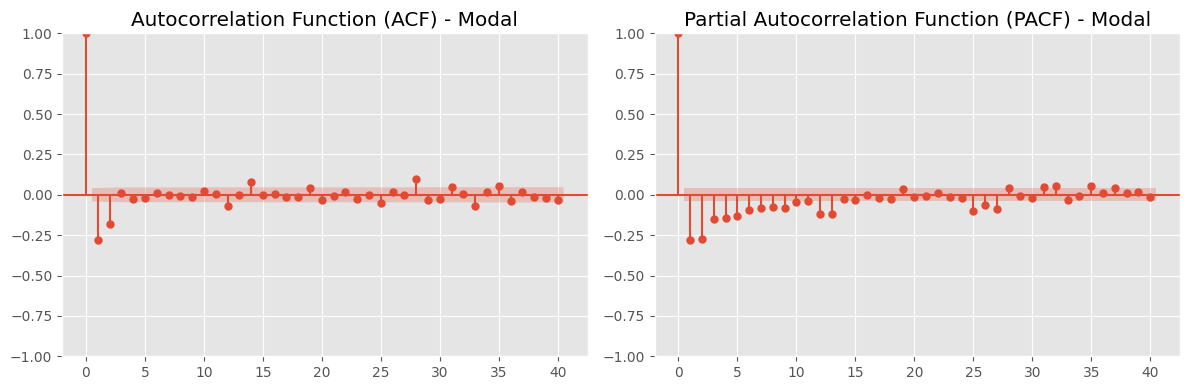

In [271]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Create a copy of grouped_df
df_copy = grouped_df.copy()

# Ensure Date column is in datetime format
df_copy['Date'] = pd.to_datetime(df_copy['Date'])
df_copy.set_index('Date', inplace=True)

# List of price columns
price_columns = ['Max', 'Min', 'Modal']

# Function to perform ADF test
def adf_test(series, column_name):
    result = adfuller(series.dropna())  # Drop NaN values before testing
    print(f"\nADF Test for {column_name}:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    if result[1] <= 0.05:
        print(f"✅ {column_name} is stationary (Reject H0)")
        return True  # Stationary
    else:
        print(f"❌ {column_name} is NOT stationary (Fail to reject H0), applying differencing")
        return False  # Not stationary

# Function to plot ACF & PACF
def plot_acf_pacf(series, column_name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # ACF Plot
    sm.graphics.tsa.plot_acf(series.dropna(), lags=40, ax=axes[0])
    axes[0].set_title(f"Autocorrelation Function (ACF) - {column_name}")

    # PACF Plot
    sm.graphics.tsa.plot_pacf(series.dropna(), lags=40, ax=axes[1])
    axes[1].set_title(f"Partial Autocorrelation Function (PACF) - {column_name}")

    plt.tight_layout()
    plt.show()

# Apply ADF test, differencing if needed, and replot ACF/PACF
for col in price_columns:
    if not adf_test(df_copy[col], col):  # If non-stationary
        df_copy[col] = df_copy[col].diff()  # Apply first-order differencing
        adf_test(df_copy[col], f"{col} (Differenced)")  # Re-run ADF test
        plot_acf_pacf(df_copy[col], col)  # Replot ACF & PACF


## Applied basic MLR(Lag Features) ,Moving Avg , ARIMA , LSTM , GRU 

In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

# Load dataset
df_forecast = grouped_df.copy() 

window_size = 7  # 
df_forecast['Max'] = df_forecast['Max'].rolling(window=window_size).mean()
df_forecast['Min'] = df_forecast['Min'].rolling(window=window_size).mean()
df_forecast['Modal'] = df_forecast['Modal'].rolling(window=window_size).mean()

df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
df_forecast = df_forecast.set_index('Date')

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_performance(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}, MAPE: {mape:.4f}%\n")
    return mae, mse, r2, mape

# Split into train & test (last 6 months for testing)
cutoff_date = df_forecast.index.max() - pd.DateOffset(months=6)
train_df = df_forecast[df_forecast.index <= cutoff_date]
test_df = df_forecast[df_forecast.index > cutoff_date]

# Columns to forecast
columns_to_forecast = ['Max', 'Min', 'Modal']
results = {}

for col in columns_to_forecast:
    print(f"\nProcessing {col} Prices:\n")
    
    # --------- Model 1: Multiple Linear Regression with Lag Features ---------
    for lag in range(1, 4):
        train_df[f'Lag_{lag}'] = train_df[col].shift(lag)
        test_df[f'Lag_{lag}'] = test_df[col].shift(lag)
    
    train_df = train_df.dropna()
    test_df = test_df.dropna()
    
    X_train = train_df[[f'Lag_{i}' for i in range(1, 4)]]
    y_train = train_df[col]
    X_test = test_df[[f'Lag_{i}' for i in range(1, 4)]]
    y_test = test_df[col]
    
    mlr = LinearRegression()
    mlr.fit(X_train, y_train)
    y_pred_mlr = mlr.predict(X_test)
    results[f"MLR_{col}"] = evaluate_performance(y_test, y_pred_mlr, f"MLR ({col})")
    
    # --------- Model 2: Moving Average ---------
    df_forecast[f'SMA_7_{col}'] = df_forecast[col].rolling(window=7).mean()
    y_pred_ma = df_forecast.loc[test_df.index, f'SMA_7_{col}'].dropna()
    results[f"Moving_Avg_{col}"] = evaluate_performance(y_test, y_pred_ma, f"Moving Average ({col})")
    
    # --------- Model 3: ARIMA ---------
    model_arima = ARIMA(train_df[col], order=(1,1,1))
    model_arima_fit = model_arima.fit()
    y_pred_arima = model_arima_fit.forecast(steps=len(test_df))
    results[f"ARIMA_{col}"] = evaluate_performance(y_test, y_pred_arima, f"ARIMA ({col})")
    
    # --------- Model 4: LSTM ---------
    n_steps = 10  # Sequence length
    
    def create_sequences(data, n_steps):
        X, y = [], []
        for i in range(n_steps, len(data)):
            X.append(data[i-n_steps:i])
            y.append(data[i])
        return np.array(X), np.array(y)
    
    X_train_lstm, y_train_lstm = create_sequences(train_df[col].values, n_steps)
    X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
    
    model_lstm = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, 1)),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mse')
    model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, verbose=0)
    
    X_test_lstm = train_df[col].values[-n_steps:].tolist()
    y_pred_lstm = []
    for _ in range(len(test_df)):
        X = np.array(X_test_lstm[-n_steps:]).reshape((1, n_steps, 1))
        y_pred = model_lstm.predict(X, verbose=0)
        y_pred_lstm.append(y_pred[0, 0])
        X_test_lstm.append(y_pred[0, 0])
    
    results[f"LSTM_{col}"] = evaluate_performance(y_test, np.array(y_pred_lstm), f"LSTM ({col})")
    
    # --------- Model 5: GRU ---------
    model_gru = Sequential([
        GRU(50, activation='relu', return_sequences=True, input_shape=(n_steps, 1)),
        Dropout(0.2),
        GRU(50, activation='relu'),
        Dense(1)
    ])
    model_gru.compile(optimizer='adam', loss='mse')
    model_gru.fit(X_train_lstm, y_train_lstm, epochs=50, verbose=0)
    
    X_test_gru = train_df[col].values[-n_steps:].tolist()
    y_pred_gru = []
    for _ in range(len(test_df)):
        X = np.array(X_test_gru[-n_steps:]).reshape((1, n_steps, 1))
        y_pred = model_gru.predict(X, verbose=0)
        y_pred_gru.append(y_pred[0, 0])
        X_test_gru.append(y_pred[0, 0])
    
    results[f"GRU_{col}"] = evaluate_performance(y_test, np.array(y_pred_gru), f"GRU ({col})")

# Display all results in a table
results_df = pd.DataFrame(results, index=['MAE', 'MSE', 'R2', 'MAPE']).T
print(results_df)


Processing Max Prices:



LinearRegression()

MLR (Max) Performance:
MAE: 139.4290, MSE: 36251.9363, R2: 0.9555, MAPE: 0.2237%

Moving Average (Max) Performance:
MAE: 308.7108, MSE: 164931.6373, R2: 0.7978, MAPE: 0.4939%

ARIMA (Max) Performance:
MAE: 766.2105, MSE: 836161.7713, R2: -0.0253, MAPE: 1.1926%



LSTM (Max) Performance:
MAE: 50892.9652, MSE: 2793886903.5455, R2: -3424.8307, MAPE: 81.3388%



GRU (Max) Performance:
MAE: 55212.6242, MSE: 3202411718.0532, R2: -3925.7589, MAPE: 88.2774%


Processing Min Prices:



LinearRegression()

MLR (Min) Performance:
MAE: 1077.1428, MSE: 1925800.4418, R2: 0.8859, MAPE: 2.2555%

Moving Average (Min) Performance:
MAE: 2155.7279, MSE: 8868912.4819, R2: 0.4746, MAPE: 4.6451%

ARIMA (Min) Performance:
MAE: 3849.2986, MSE: 28062212.2115, R2: -0.6623, MAPE: 8.8851%



LSTM (Min) Performance:
MAE: 41664.2836, MSE: 1830429611.1667, R2: -107.4260, MAPE: 85.8232%



GRU (Min) Performance:
MAE: 41109.6943, MSE: 1794402846.1768, R2: -105.2919, MAPE: 84.7181%


Processing Modal Prices:



LinearRegression()

MLR (Modal) Performance:
MAE: 583.6563, MSE: 606942.3914, R2: 0.9260, MAPE: 1.0538%

Moving Average (Modal) Performance:
MAE: 1303.2937, MSE: 3786160.5418, R2: 0.5385, MAPE: 2.3885%

ARIMA (Modal) Performance:
MAE: 2336.0504, MSE: 11775719.0384, R2: -0.4352, MAPE: 4.5346%



LSTM (Modal) Performance:
MAE: 46604.9803, MSE: 2331644792.7444, R2: -283.1821, MAPE: 83.0061%



GRU (Modal) Performance:
MAE: 44592.8491, MSE: 2164518153.5889, R2: -262.8126, MAPE: 79.4370%

                           MAE           MSE           R2       MAPE
MLR_Max             139.428969  3.625194e+04     0.955548   0.223724
Moving_Avg_Max      308.710811  1.649316e+05     0.797763   0.493900
ARIMA_Max           766.210535  8.361618e+05    -0.025292   1.192632
LSTM_Max          50892.965214  2.793887e+09 -3424.830651  81.338816
GRU_Max           55212.624230  3.202412e+09 -3925.758885  88.277425
MLR_Min            1077.142821  1.925800e+06     0.885925   2.255549
Moving_Avg_Min     2155.727908  8.868912e+06     0.474648   4.645143
ARIMA_Min          3849.298582  2.806221e+07    -0.662273   8.885087
LSTM_Min          41664.283560  1.830430e+09  -107.426004  85.823175
GRU_Min           41109.694299  1.794403e+09  -105.291948  84.718147
MLR_Modal           583.656277  6.069424e+05     0.926026   1.053848
Moving_Avg_Modal   1303.293741  3.786161e+06     0.538541   2.388458
ARIMA_Mo

## After smoothing based on rolling window

LinearRegression()

Optimized MLR on Smoothed Data Performance:
MAE: 140.6635, MSE: 36771.2744, RMSE: 191.7584, MAPE: 0.2257%



(140.66346259710787, 36771.27438218703, 191.7583749988173, 0.225684488933999)

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Optimized MLR on Smoothed Data: Actual vs. Predicted')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Smoothed Max')

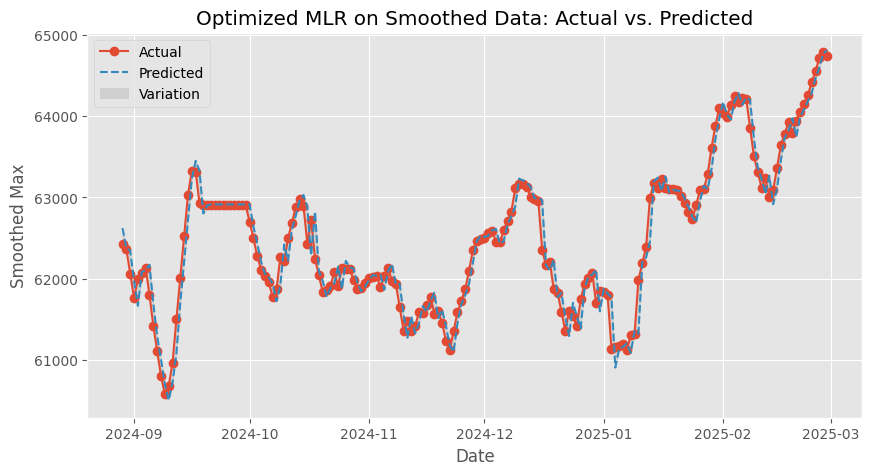

Predicted values with variations have been saved to 'predicted_vs_actual.xlsx'.


In [275]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define performance evaluation function
def evaluate_performance(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}%\n")
    return mae, mse, rmse, mape

# Load dataset
# Assuming 'grouped_df' is your original DataFrame
df = grouped_df.copy()

# Ensure 'Date' is in datetime format and set as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Smooth the 'Max' column using Simple Moving Average (SMA)
window_size = 7  # Adjust the window size as needed
df['Smoothed_Max'] = df['Max'].rolling(window=window_size).mean()

# Drop rows with NaN values resulting from the rolling operation
df = df.dropna()

# Feature Engineering for MLR
# Create time-based features
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month

# Create lag features based on the smoothed data
df['Lag1'] = df['Smoothed_Max'].shift(1)
df['Lag2'] = df['Smoothed_Max'].shift(2)
df['Lag3'] = df['Smoothed_Max'].shift(3)

# Drop rows with NaN values resulting from lag features
df = df.dropna()

cutoff_date = df.index.max() - pd.DateOffset(months=6)
train_df = df[df.index <= cutoff_date]
test_df = df[df.index > cutoff_date]

# Define features and target variable
features = ['DayOfWeek', 'Month', 'Lag1', 'Lag2', 'Lag3']
target = 'Smoothed_Max'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Initialize and train the Multiple Linear Regression model
mlr = LinearRegression()
mlr.fit(X_train, y_train)

# Make predictions
y_pred_mlr = mlr.predict(X_test)

# Evaluate performance
evaluate_performance(y_test, y_pred_mlr, "Optimized MLR on Smoothed Data")

# Visualize Actual vs. Predicted values for MLR
plt.figure(figsize=(10, 5))
plt.plot(test_df.index, y_test, label='Actual', marker='o')
plt.plot(test_df.index, y_pred_mlr, label='Predicted', linestyle='dashed')
plt.fill_between(test_df.index, y_test, y_pred_mlr, color='gray', alpha=0.2, label='Variation')
plt.legend()
plt.title("Optimized MLR on Smoothed Data: Actual vs. Predicted")
plt.xlabel('Date')
plt.ylabel('Smoothed Max')
plt.show()

# Save the results to an Excel file
# Create a DataFrame to hold actual and predicted values
results_df = pd.DataFrame({
    'Date': test_df.index,
    'Actual': y_test,
    'Predicted': y_pred_mlr
})

# Calculate the variation (difference between actual and predicted)
results_df['Variation'] = results_df['Actual'] - results_df['Predicted']

# Save the results to an Excel file
results_df.to_excel('predicted_vs_actual.xlsx', index=False)

print("Predicted values with variations have been saved to 'predicted_vs_actual.xlsx'.")


LinearRegression()

MLR with Lag features on Smoothed Data Performance:
MAE: 140.6516, MSE: 36761.6866, RMSE: 191.7334, MAPE: 0.2257%



(140.6516341646606, 36761.68663992485, 191.7333738291924, 0.22566520432762996)

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'MLR with Lag features: Actual vs. 2-Week Forecasted Smoothed Max')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Smoothed Max')

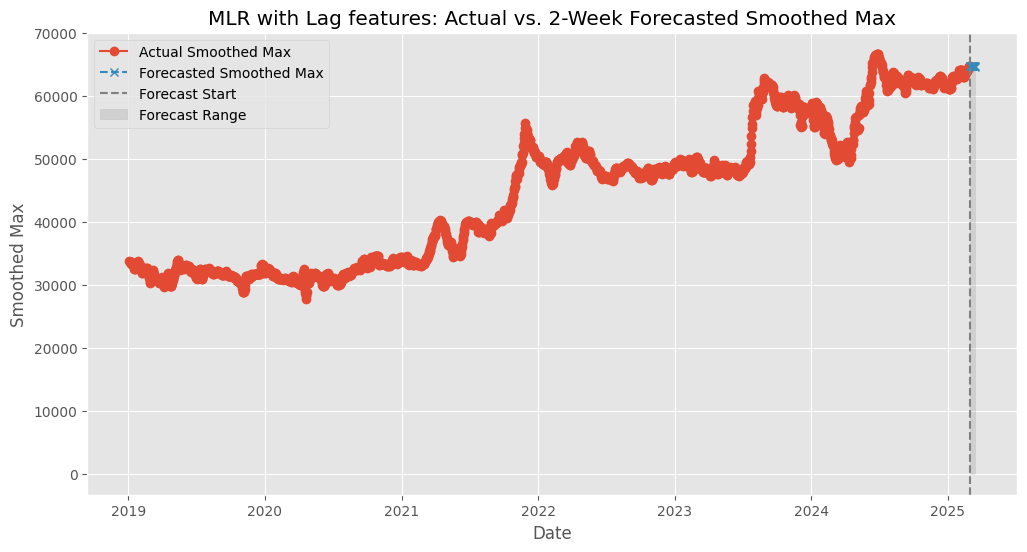

6-week forecasted values have been saved to '2_week_forecast.xlsx'.


<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'MLR with Lag features: Actual vs. Predicted Smoothed Max on Test Data')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Smoothed Max')

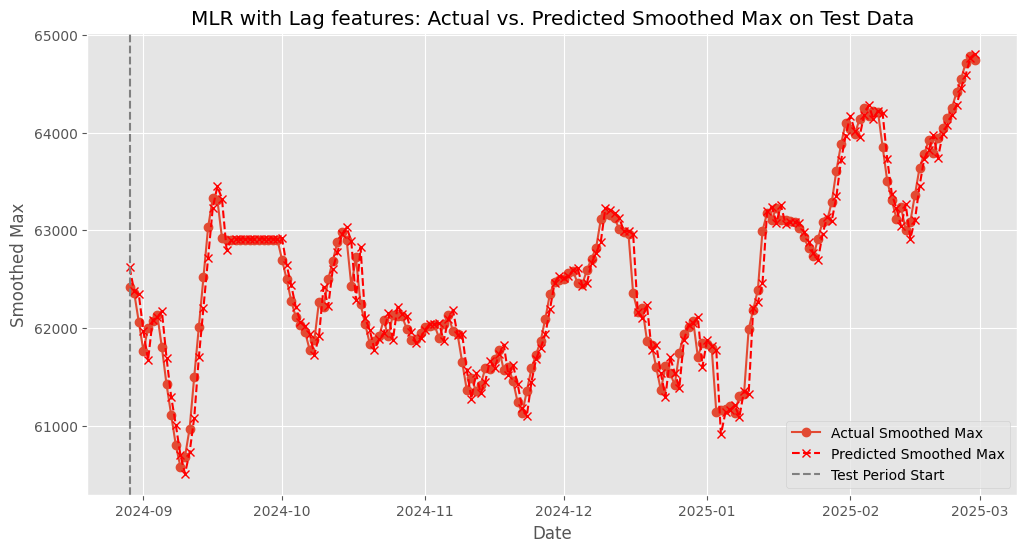

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'MLR with Lag features on Smoothed Data: Actual vs. Predicted')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Smoothed Max')

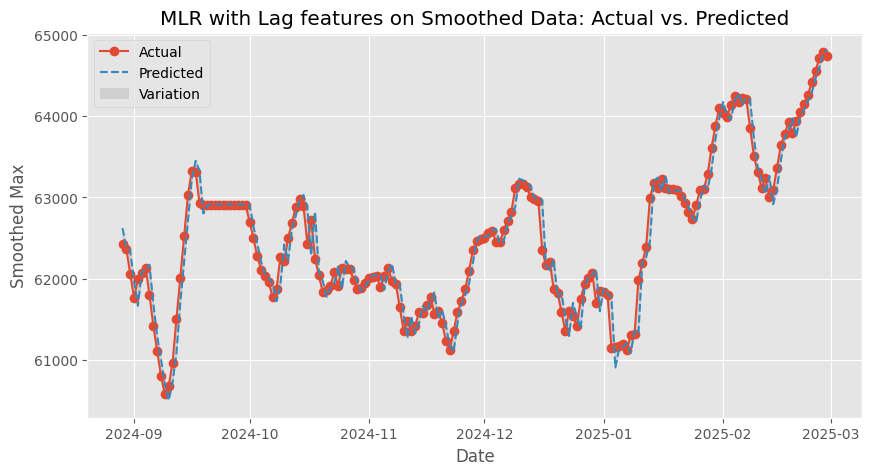

In [276]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import openpyxl

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define performance evaluation function
def evaluate_performance(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}%\n")
    return mae, mse, rmse, mape

# Load dataset
df = grouped_df.copy()  # Ensure grouped_df is defined in your environment

# Ensure 'Date' is in datetime format and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Apply a rolling mean to smooth the 'Max' column
window_size = 7  # 7-day window for smoothing
df['Smoothed_Max'] = df['Max'].rolling(window=window_size, min_periods=1).mean()

# Feature Engineering for MLR
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month

# Create lag features based on the smoothed data
for lag in range(1, 4):  # Creating Lag1, Lag2, Lag3
    df[f'Lag{lag}'] = df['Smoothed_Max'].shift(lag)

# Drop NaN values resulting from shifting
df.dropna(inplace=True)

# Split into train and test sets
cutoff_date = df.index.max() - pd.DateOffset(months=6)
train_df = df[df.index <= cutoff_date]
test_df = df[df.index > cutoff_date]

# Define features and target variable
features = ['DayOfWeek', 'Month', 'Lag1', 'Lag2', 'Lag3']
target = 'Smoothed_Max'

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

# Initialize and train the Multiple Linear Regression model
mlr = LinearRegression()
mlr.fit(X_train, y_train)

# Make predictions on the test set
y_pred_mlr = mlr.predict(X_test)

# Evaluate performance on the test set
evaluate_performance(y_test, y_pred_mlr, "MLR with Lag features on Smoothed Data")

# Forecasting the next 42 days (6 weeks)
last_date = df.index[-1]
last_values = df.iloc[-1][['Lag1', 'Lag2', 'Lag3']].values

forecast_dates = []
forecast_values = []

for i in range(1, 15):  # Forecasting 15 days
    next_date = last_date + pd.Timedelta(days=i)
    next_day_of_week = next_date.dayofweek
    next_month = next_date.month

    # Prepare the input features for prediction
    next_features = np.array([next_day_of_week, next_month] + list(last_values))
    next_features = next_features.reshape(1, -1)

    # Predict the next value
    next_pred = mlr.predict(next_features)[0]

    # Update the lag values
    last_values = np.roll(last_values, 1)
    last_values[0] = next_pred

    # Store the forecasted date and value
    forecast_dates.append(next_date)
    forecast_values.append(next_pred)

forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted_Smoothed_Max': forecast_values})
forecast_df.set_index('Date', inplace=True)

# Combine actual and forecasted data for visualization
combined_df = pd.concat([df[['Smoothed_Max']], forecast_df])

# Visualize Actual vs. Forecasted values
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Smoothed_Max'], label='Actual Smoothed Max', marker='o')
plt.plot(forecast_df.index, forecast_df['Forecasted_Smoothed_Max'], label='Forecasted Smoothed Max', linestyle='dashed', marker='x')
plt.axvline(x=last_date, color='gray', linestyle='--', label='Forecast Start')
plt.fill_between(forecast_df.index, forecast_df['Forecasted_Smoothed_Max'], color='gray', alpha=0.2, label='Forecast Range')
plt.legend()
plt.title("MLR with Lag features: Actual vs. 2-Week Forecasted Smoothed Max")
plt.xlabel('Date')
plt.ylabel('Smoothed Max')
plt.grid(True)
plt.show()

# Save the forecasted values to an Excel file
forecast_df.to_excel('2_week_forecast.xlsx')

print("6-week forecasted values have been saved to '2_week_forecast.xlsx'.")

# Plot Actual vs. Predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, y_test, label='Actual Smoothed Max', marker='o')
plt.plot(test_df.index, y_pred_mlr, label='Predicted Smoothed Max', linestyle='dashed', marker='x', color='red')
plt.axvline(x=test_df.index[0], color='gray', linestyle='--', label='Test Period Start')
plt.legend()
plt.title("MLR with Lag features: Actual vs. Predicted Smoothed Max on Test Data")
plt.xlabel('Date')
plt.ylabel('Smoothed Max')
plt.grid(True)
plt.show()

# Visualize Actual vs. Predicted values for MLR
plt.figure(figsize=(10, 5))
plt.plot(test_df.index, y_test, label='Actual', marker='o')
plt.plot(test_df.index, y_pred_mlr, label='Predicted', linestyle='dashed')
plt.fill_between(test_df.index, y_test, y_pred_mlr, color='gray', alpha=0.2, label='Variation')
plt.legend()
plt.title("MLR with Lag features on Smoothed Data: Actual vs. Predicted")
plt.xlabel('Date')
plt.ylabel('Smoothed Max')
plt.show()

LinearRegression()

Optimized MLR Performance:
MAE: 158.4567, MSE: 46172.7406, RMSE: 214.8784, MAPE: 0.2546%



(158.45668552898363,
 46172.740601659934,
 214.87843214631835,
 0.25463486363424076)

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'MLR with Lag features: Test Data - Actual vs. Predicted')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Max Price')

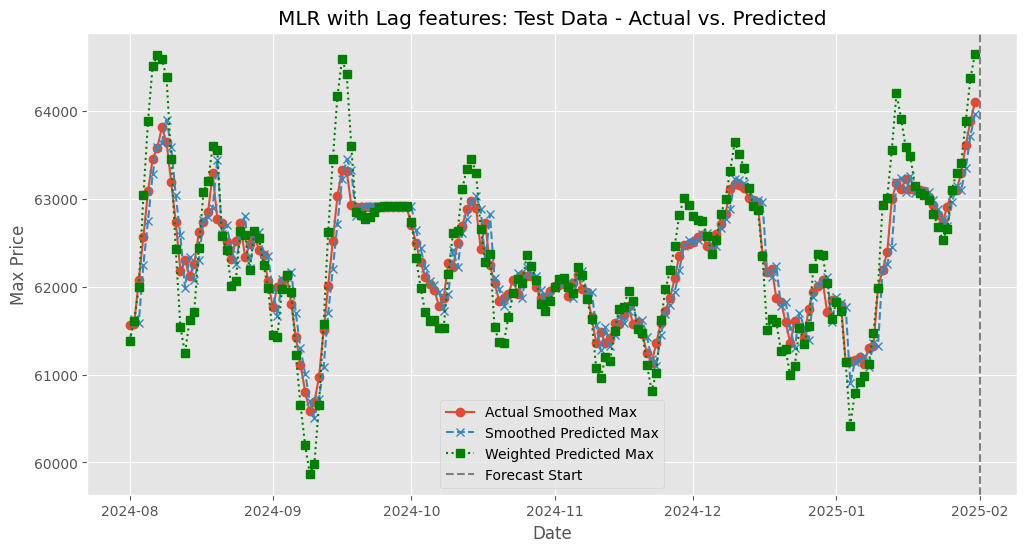

Forecasting for Feb 2025 completed. Results saved to Excel.


In [277]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import openpyxl

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define performance evaluation function
def evaluate_performance(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}%\n")
    return mae, mse, rmse, mape

# Load dataset
df = grouped_df.copy()

# Ensure 'Date' is in datetime format and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# **Filter dataset till Jan 2025**
df = df[df.index <= '2025-01-31']

# Apply rolling mean smoothing
df['Smoothed_Max'] = df['Max'].rolling(window=7, min_periods=1).mean()

# Compute past 7-day weight distribution
for i in range(7):
    df[f'Weight_Day{i+1}'] = df['Max'].shift(i) / df['Smoothed_Max'].shift(i)

df['Weight_Avg'] = df[[f'Weight_Day{i+1}' for i in range(7)]].mean(axis=1)

df.dropna(inplace=True)

# Feature Engineering
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month

# Create lag features
for lag in range(1, 4):
    df[f'Lag{lag}'] = df['Smoothed_Max'].shift(lag)

df.dropna(inplace=True)

# **Split train-test based on September 2024 cutoff**
df_train = df[df.index < '2024-08-01']  # Train data till Aug 2024
df_test = df[df.index >= '2024-08-01']  # Test data from Aug 2024 to Jan 2025 ( 6 months)

# Define features and target
features = ['DayOfWeek', 'Month', 'Lag1', 'Lag2', 'Lag3']
target = 'Smoothed_Max'

X_train, y_train = df_train[features], df_train[target]
X_test, y_test = df_test[features], df_test[target]

# Train Model
mlr = LinearRegression()
mlr.fit(X_train, y_train)

# Predictions
df_test['Smoothed_Predicted_Max'] = mlr.predict(X_test)

# Convert smoothed predicted values to actual price predictions
df_test['Weighted_Predicted_Max'] = df_test['Smoothed_Predicted_Max'] * df_test['Weight_Avg']

# Evaluate Performance
evaluate_performance(df_test['Smoothed_Max'], df_test['Smoothed_Predicted_Max'], "Optimized MLR")

# **Forecasting for October 2024**
forecast_start = pd.Timestamp('2025-02-01')
forecast_end = pd.Timestamp('2025-02-28')

forecast_dates = pd.date_range(start=forecast_start, end=forecast_end)
forecast_values = []

last_values = df.iloc[-1][['Lag1', 'Lag2', 'Lag3']].values

for next_date in forecast_dates:
    next_features = np.array([next_date.dayofweek, next_date.month] + list(last_values)).reshape(1, -1)
    next_pred = mlr.predict(next_features)[0]
    last_values = np.roll(last_values, 1)
    last_values[0] = next_pred
    forecast_values.append(next_pred)

forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted_Smoothed_Max': forecast_values})
forecast_df.set_index('Date', inplace=True)

# Convert smoothed forecast to actual daily prices using recent weight distribution
latest_weight_avg = df['Weight_Avg'].iloc[-7:].values
forecast_df['Actual_Forecasted_Max'] = forecast_df['Forecasted_Smoothed_Max'] * latest_weight_avg.mean()

# Save to Excel
with pd.ExcelWriter("Test_vs_Forecast_Feb2025.xlsx") as writer:
    df_test[['Max', 'Smoothed_Max', 'Smoothed_Predicted_Max', 'Weighted_Predicted_Max']].to_excel(writer, sheet_name="Test_Actual_vs_Predicted")
    forecast_df.to_excel(writer, sheet_name="Feb_2025_Forecast")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test['Smoothed_Max'], label='Actual Smoothed Max', marker='o')
plt.plot(df_test.index, df_test['Smoothed_Predicted_Max'], label='Smoothed Predicted Max', linestyle='dashed', marker='x')
plt.plot(df_test.index, df_test['Weighted_Predicted_Max'], label='Weighted Predicted Max', linestyle='dotted', marker='s', color='green')
plt.axvline(x=forecast_start, color='gray', linestyle='--', label='Forecast Start')
plt.legend()
plt.title("MLR with Lag features: Test Data - Actual vs. Predicted")
plt.xlabel('Date')
plt.ylabel('Max Price')
plt.grid(True)
plt.show()

print("Forecasting for Feb 2025 completed. Results saved to Excel.")


In [278]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load actual Feb 2025 data
actual_feb_data = grouped_df[(grouped_df['Date'] >= '2025-02-01') & (grouped_df['Date'] <= '2025-02-28')].copy()
# Convert 'Date' to index
actual_feb_data['Date'] = pd.to_datetime(actual_feb_data['Date'])
actual_feb_data.set_index('Date', inplace=True)

# Merge forecasted and actual values
comparison_df = forecast_df.merge(actual_feb_data[['Max']], left_index=True, right_index=True, how='inner')

# Compute absolute errors
comparison_df['Absolute_Error'] = np.abs(comparison_df['Actual_Forecasted_Max'] - comparison_df['Max'])
comparison_df['Percentage_Error'] = (comparison_df['Absolute_Error'] / comparison_df['Max']) * 100

# Evaluate Performance
mae = mean_absolute_error(comparison_df['Max'], comparison_df['Actual_Forecasted_Max'])
mse = mean_squared_error(comparison_df['Max'], comparison_df['Actual_Forecasted_Max'])
rmse = np.sqrt(mse)
mape = np.mean(comparison_df['Percentage_Error'])

print("Feb 2025 Forecast Performance:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}%\n")

# Save to Excel
with pd.ExcelWriter("Test_vs_Forecast_Feb2025.xlsx", mode='a', engine='openpyxl') as writer:
    comparison_df.to_excel(writer, sheet_name="Actual_vs_Forecast_Feb2025")

print("Analysis saved to Excel. Check the 'Actual_vs_Forecast_Feb2025' sheet for details.")


Feb 2025 Forecast Performance:
MAE: 660.0489, MSE: 805669.2398, RMSE: 897.5908, MAPE: 1.0396%

Analysis saved to Excel. Check the 'Actual_vs_Forecast_Feb2025' sheet for details.
